Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import transforms, datasets
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader
import torch.nn.init
from torchvision.transforms.functional import to_pil_image
from skimage.util import invert
import cv2

Setting

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

Training Data Load

In [130]:
Image_folder=datasets.ImageFolder(root='dataset/train/',
                                   transform=transforms.Compose([
                                       transforms.Resize(size=(64,64)),
                                       transforms.ToTensor()
                                   ]))
print(Image_folder.class_to_idx)
                                          
train_vehicles=DataLoader(Image_folder,
                                          batch_size=10,
                                          shuffle=True,
                                          )

print(type(train_vehicles))
images, labels = next(iter(train_vehicles))



{'non-vehicles': 0, 'vehicles': 1}
<class 'torch.utils.data.dataloader.DataLoader'>


Labeling check

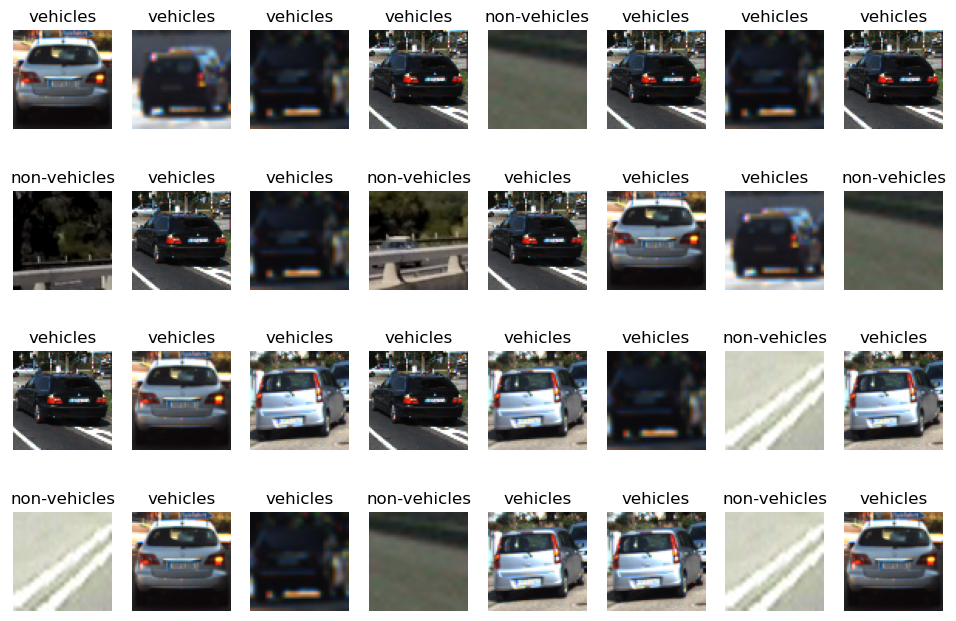

In [131]:
labels_map = {v:k for k, v in Image_folder.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# print image
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

ResNet

In [133]:
class ResBlock(nn.Module):
	def __init__(self, block):
		super().__init__()
		self.block = block
	def forward(self, x):
		return self.block(x) + x #f(x) + x

In [134]:
class Conv6Res(nn.Module):
  def __init__(self):
    super().__init__()
    self.name = 'conv6res'
    self.model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1,padding=1),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),

        ResBlock(
            nn.Sequential(
                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1,padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1,padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU()
            )
        ),

        ResBlock(
            nn.Sequential(
                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1,padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1,padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1,padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
            )
        ),
        nn.Flatten(),
        nn.Linear(64*64*32, 256),
        nn.ReLU(),
        nn.Linear(256, 2)
    )
  def forward(self, x):
    return self.model(x)

Training

In [190]:
model=Conv6Res()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

total_batch = len(train_vehicles)

#train
for epoch in range(5):
    avg_cost=0
    model.train()
    count=0
    for X,Y in train_vehicles:
        X=X.to(device)
        Y=Y.to(device)
        hypothesis=model(X)
        cost=criterion(hypothesis,Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        avg_cost+=cost/total_batch
        
    print(avg_cost)

tensor(1.7129, grad_fn=<AddBackward0>)
tensor(0.0368, grad_fn=<AddBackward0>)
tensor(0.0240, grad_fn=<AddBackward0>)
tensor(0.0283, grad_fn=<AddBackward0>)
tensor(0.0532, grad_fn=<AddBackward0>)


Test data accuracy check

In [191]:
test_Image_folder=datasets.ImageFolder(root='dataset/test/',
                                   transform=transforms.Compose([
                                       transforms.Resize(size=(64,64)),
                                       transforms.ToTensor()
                                   ]))
test_vehicles=DataLoader(test_Image_folder,
                                          batch_size=10,
                                          shuffle=True,
                                          )

#check accuracy
with torch.no_grad():

    corr=0
    
    running_loss = 0

    for X,Y in test_vehicles:
        X,Y=X.to(device),Y.to(device)

        output=model(X)
        _,pred=output.max(dim=1)
        corr+=torch.sum(pred.eq(Y)).item()
        running_loss+=criterion(hypothesis,Y).item()*X.size(0)
    acc=corr/len(test_vehicles.dataset)

    print(running_loss/len(test_vehicles.dataset),acc)


15.795321317127673 0.98


Show image with predict result

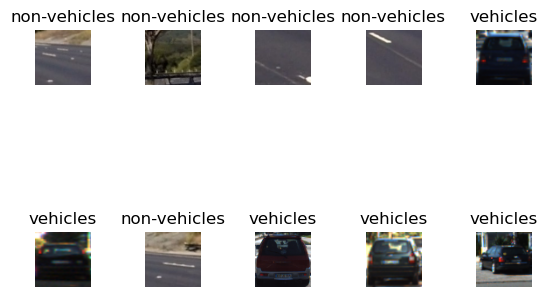

In [192]:
with torch.no_grad():
    
    for X,Y in test_vehicles:
        X,Y=X.to(device),Y.to(device)
        output=model(X)
        _,pred=output.max(dim=1)
    
        plt.figure()
        plt.subplots_adjust(wspace=1)
        for i in range(10):
            plt.subplot(2,5,i+1)
            plt.imshow(to_pil_image(X[i]))
            plt.axis('off')
            if pred[i]==1:
                plt.title('vehicles')
            else:
                plt.title('non-vehicles')
        break